In [433]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA


from scipy.stats import skew, kurtosis

df = pd.read_csv(r'D:\Randomwalk\randomwalk-ds-assessment-level2\dataset.csv')

continuous_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_columns = ['species', 'island', 'sex']
print("Dataframe Shape: ", df.shape)

Dataframe Shape:  (344, 7)


In [434]:
def detect_outliers_iqr(df, continuous_columns):
    # Dictionary to hold the outlier limits for each column
    outlier_limits = {}
    
    for col in continuous_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Store the outlier limits for future reference
        outlier_limits[col] = (lower_bound, upper_bound)

        # Filter out rows that have outliers in the column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df, outlier_limits


In [435]:
# Remove incorrect data

print("Continuous columns (Min - Max values):")
for col in continuous_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: Min = {min_val}, Max = {max_val}")

df = df[df['body_mass_g']<=6300]
df['sex'] = df['sex'].replace('unknown', np.nan)


Continuous columns (Min - Max values):
bill_length_mm: Min = 32.1, Max = 59.6
bill_depth_mm: Min = 13.1, Max = 21.5
flipper_length_mm: Min = 172.0, Max = 231.0
body_mass_g: Min = 2700.0, Max = 15000.0


In [436]:
df[df['sex'] == 'unknown']

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex


In [437]:
# Step 1: Store rows with null values
df_null_rows = df[df.isnull().any(axis=1)]

# Step 2: Drop rows with any missing values from original dataframe and clean the continuous columns
df_non_null_rows = df.dropna()

# Apply outlier detection and removal on the rows without null values
df_clean, outlier_limits = detect_outliers_iqr(df_non_null_rows, continuous_columns)

# Step 3: Concatenate the cleaned dataframe and the rows that had null values
df = pd.concat([df_clean, df_null_rows], ignore_index=True)

# To check the outlier limits for each column:
print("Outlier limits for each column:")
for col, limits in outlier_limits.items():
    print(f"{col}: Lower bound = {limits[0]}, Upper bound = {limits[1]}")
    
print("Dataframe Shape: ", df.shape)

Outlier limits for each column:
bill_length_mm: Lower bound = 25.250000000000007, Upper bound = 62.449999999999996
bill_depth_mm: Lower bound = 11.049999999999999, Upper bound = 23.25
flipper_length_mm: Lower bound = 155.5, Upper bound = 247.5
body_mass_g: Lower bound = 1750.0, Upper bound = 6550.0
Dataframe Shape:  (339, 7)


In [438]:
print("Null values:")
print(df.isnull().sum())


Null values:
species               0
island                0
bill_length_mm        5
bill_depth_mm         0
flipper_length_mm     0
body_mass_g           0
sex                  16
dtype: int64


c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

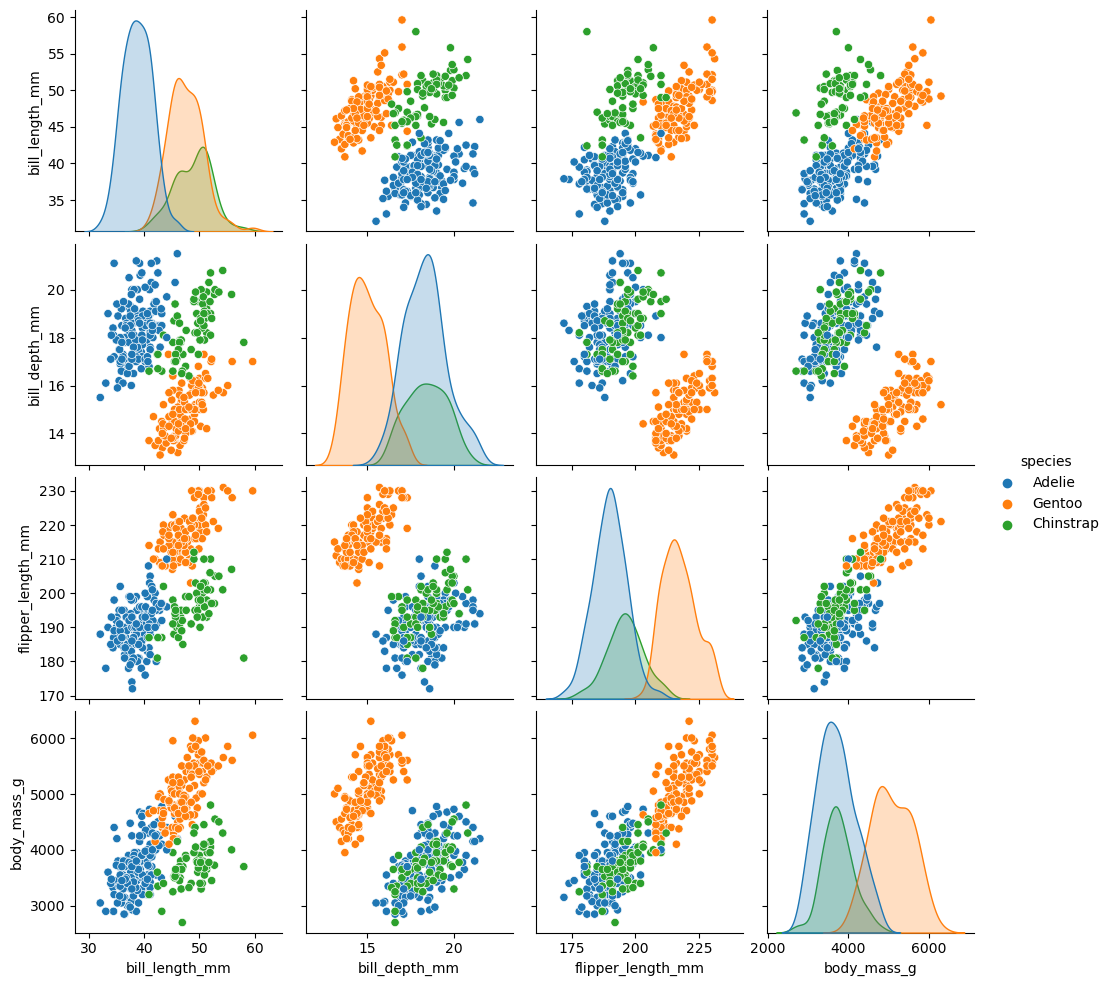

In [439]:
sns.pairplot(df, hue='species', diag_kind='kde')
plt.show()


c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

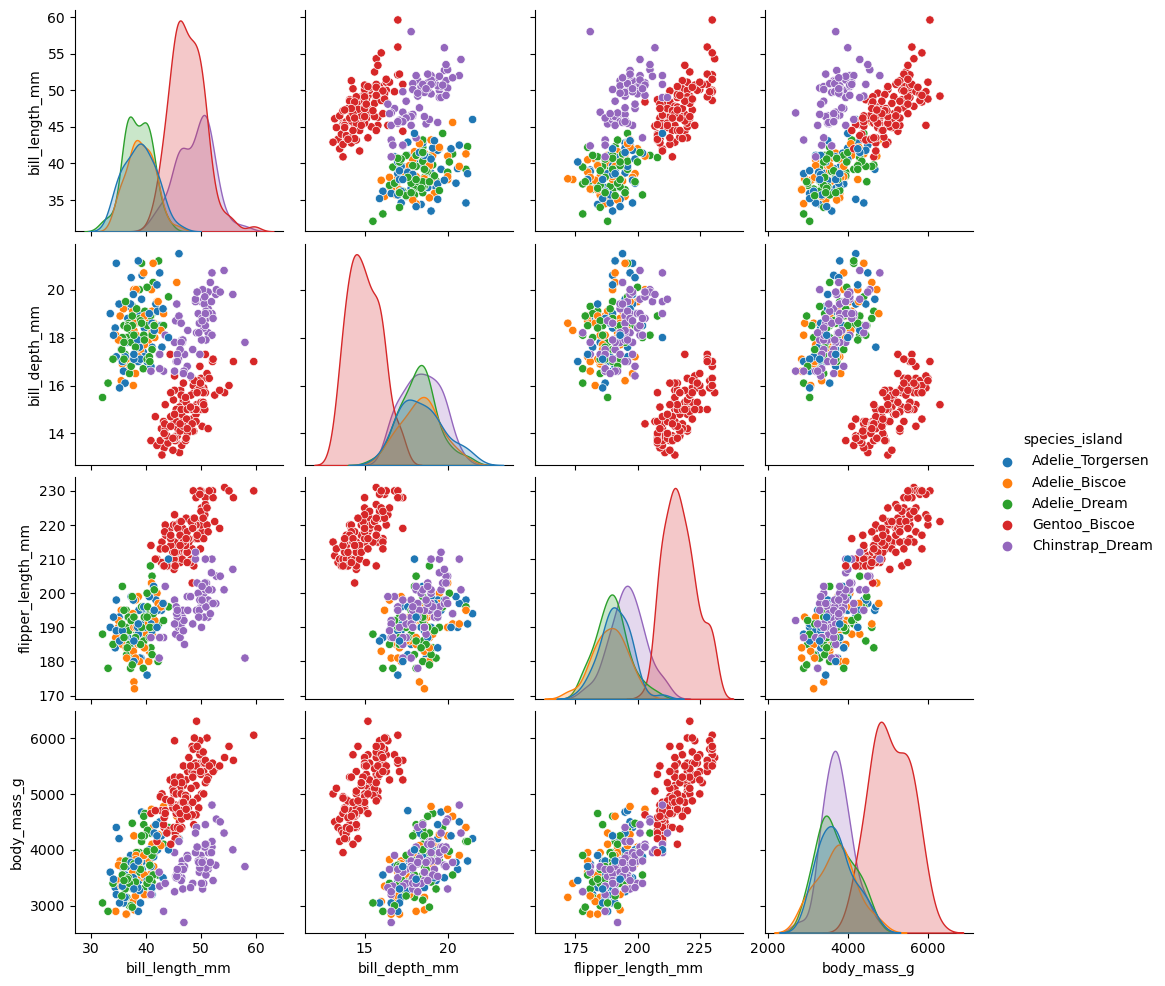

In [440]:
df2 = df.copy()
df2['species_island'] = df['species'] + '_' + df['island']

# Create the pairplot with the new hue column
sns.pairplot(df2, hue='species_island', diag_kind='kde')
plt.show()


Observations:
- Female Gentoo penguins from Biscoe Island have higher weights compared to female penguins of other species.
- Gentoo penguins are exclusively found on Biscoe Island.
- Chinstrap penguins are only located on Dream Island.
- Female penguins generally weigh less than their male counterparts.

Based on the pair plots of species and islands, we can observe that only Gentoo_Biscoe forms a distinct cluster separate from the other species-island combinations. This is because the Gentoo species is exclusively found on Biscoe Island, while the other species-island groups overlap significantly. Therefore, we can utilize the categorical mean based on species for further analysis.

In [441]:
# Fill missing values in continuous columns with the mean per species
for col in continuous_columns:
    df[col] = df.groupby('species')[col].transform(lambda x: x.fillna(x.mean()))

# Check the remaining null values
df.isnull().sum()

species               0
island                0
bill_length_mm        0
bill_depth_mm         0
flipper_length_mm     0
body_mass_g           0
sex                  16
dtype: int64

Filling missing sex values, 
Sex may correlate with the bill_length, bill_depth, flipper_length, body_mass

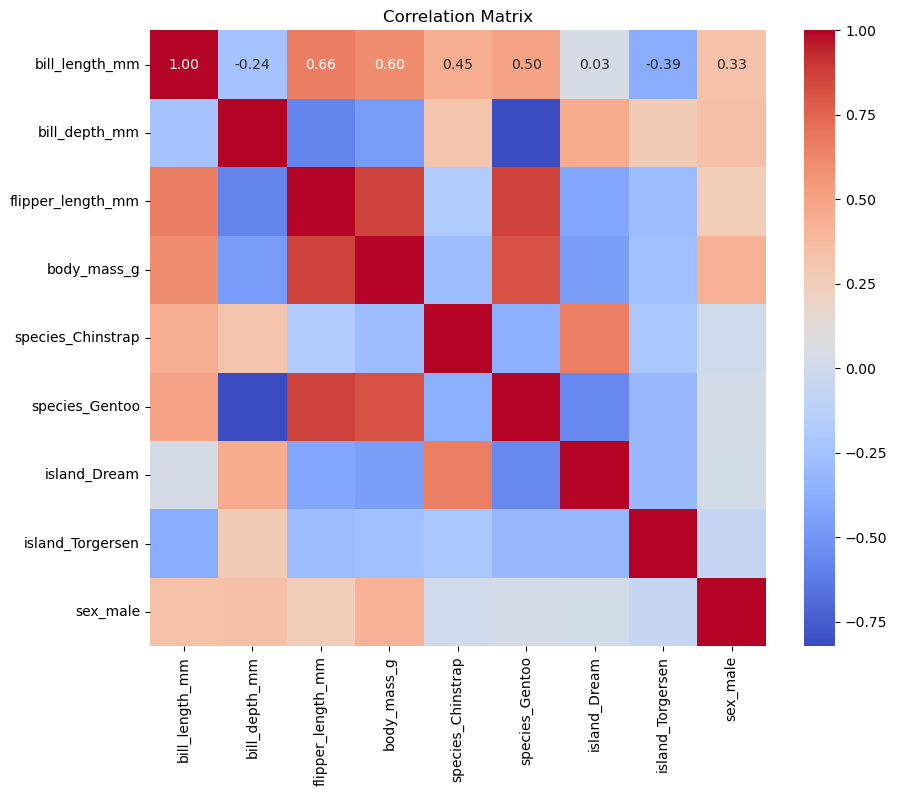

In [442]:
# One-hot encoding of categorical columns
encoded_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)

# Combine the numerical and encoded categorical columns
combined_df = pd.concat([df[numerical_cols], encoded_categorical], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


From the correlation matrix, we can observe that the sex of the penguin is correlated with all four numerical columns. This indicates that the sex variable may have a significant relationship with the numerical features. Consequently, we could employ clustering techniques to impute the missing values in the sex column based on the identified patterns within the numerical data.

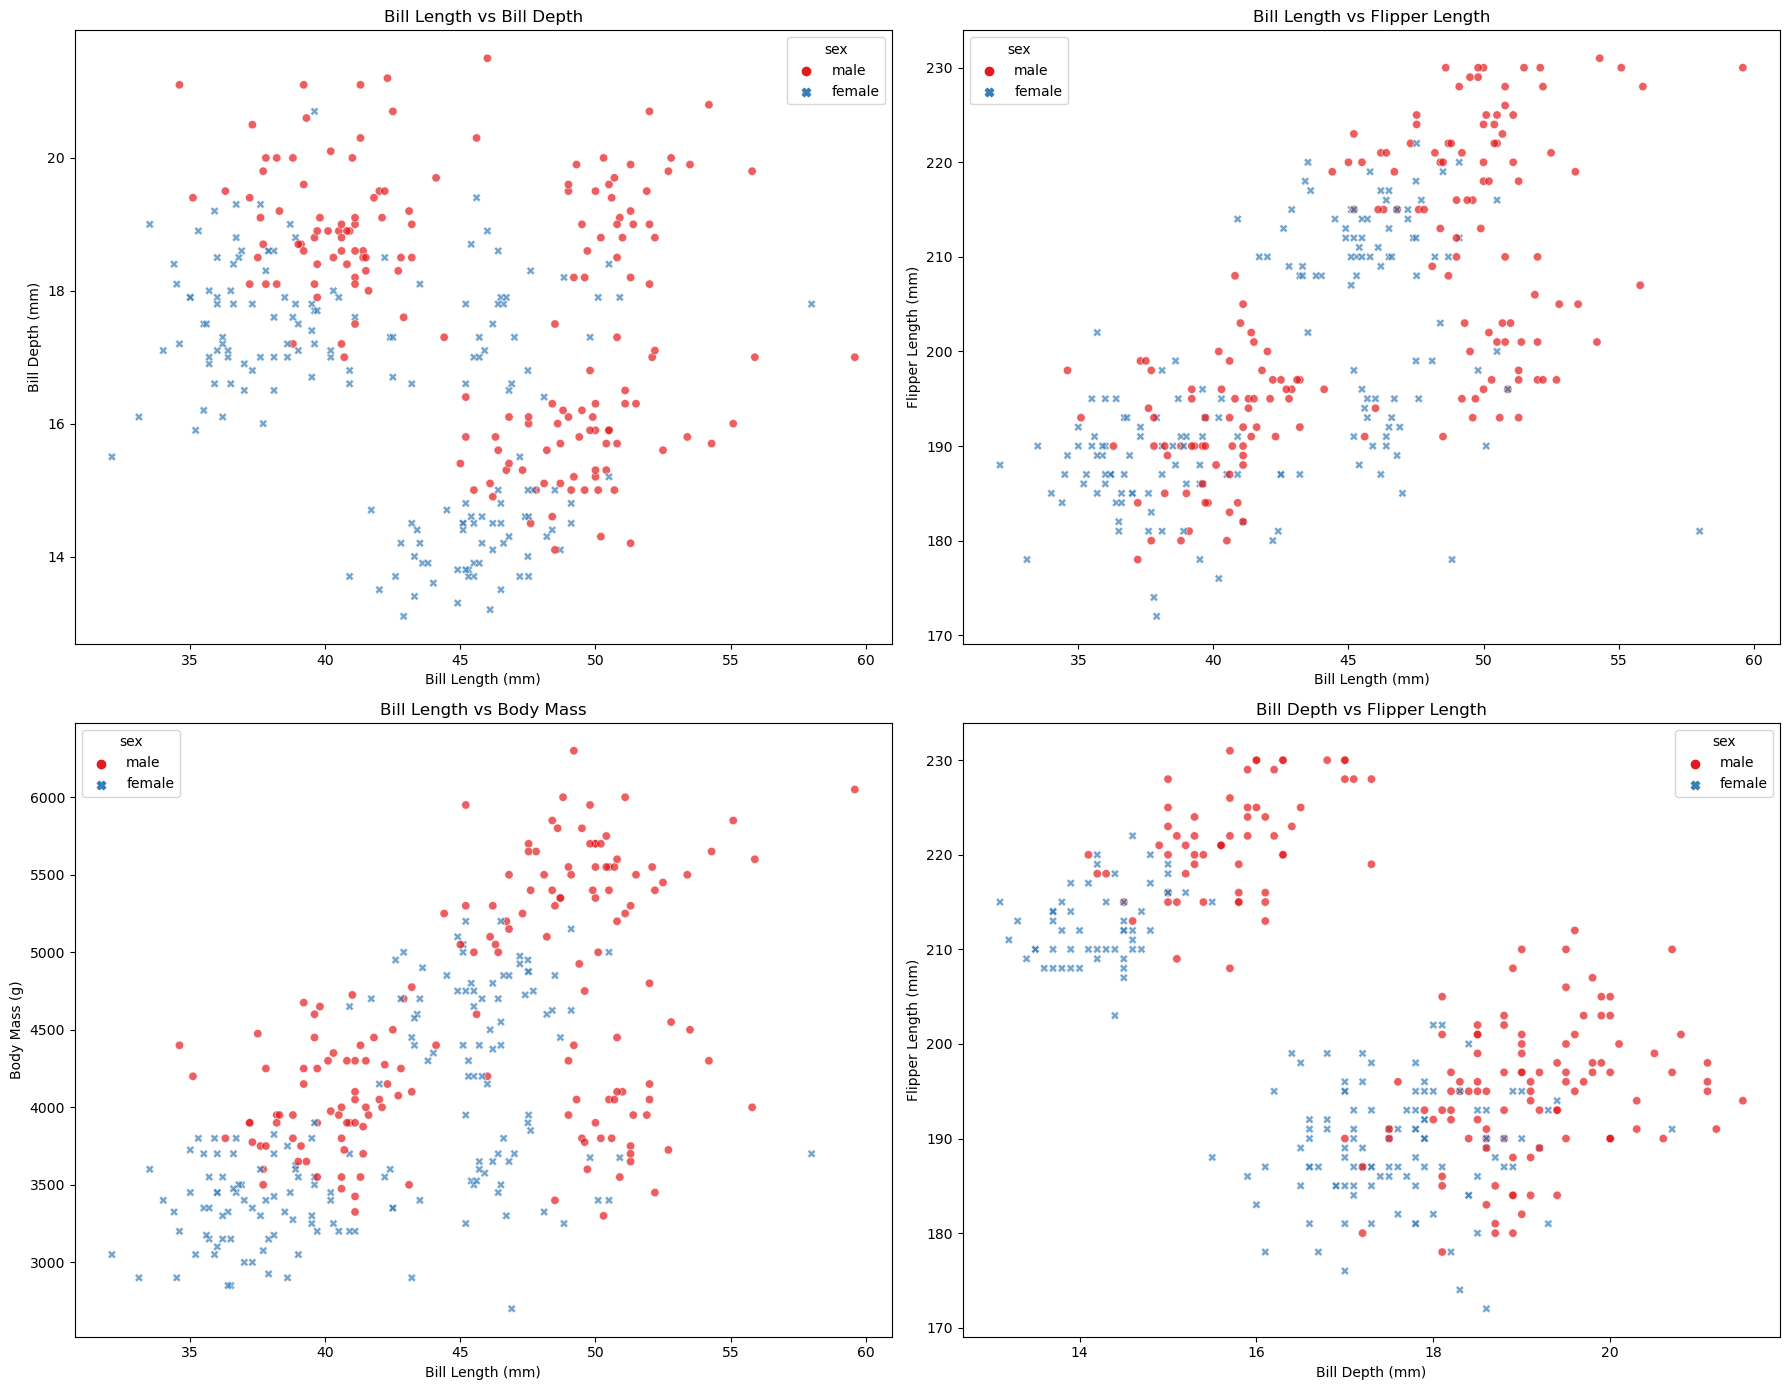

In [443]:
# Define the numerical columns
numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Create a pair of scatter plots for each combination of numerical features
plt.figure(figsize=(18, 14))

# Plot 1: Bill Length vs Bill Depth
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='bill_length_mm', y='bill_depth_mm', hue='sex', palette='Set1', style='sex', markers=['o', 'X'], alpha=0.7)
plt.title('Bill Length vs Bill Depth')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Bill Depth (mm)')

# Plot 2: Bill Length vs Flipper Length
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='bill_length_mm', y='flipper_length_mm', hue='sex', palette='Set1', style='sex', markers=['o', 'X'], alpha=0.7)
plt.title('Bill Length vs Flipper Length')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Flipper Length (mm)')

# Plot 3: Bill Length vs Body Mass
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='bill_length_mm', y='body_mass_g', hue='sex', palette='Set1', style='sex', markers=['o', 'X'], alpha=0.7)
plt.title('Bill Length vs Body Mass')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Body Mass (g)')

# Plot 4: Bill Depth vs Flipper Length
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='bill_depth_mm', y='flipper_length_mm', hue='sex', palette='Set1', style='sex', markers=['o', 'X'], alpha=0.7)
plt.title('Bill Depth vs Flipper Length')
plt.xlabel('Bill Depth (mm)')
plt.ylabel('Flipper Length (mm)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Based on the above plots, we can focus on the relationship between flipper length and bill depth to use K-Nearest Neighbors (KNN) for predicting gender, varying the value of K.

In [444]:
df.isnull().sum()

species               0
island                0
bill_length_mm        0
bill_depth_mm         0
flipper_length_mm     0
body_mass_g           0
sex                  16
dtype: int64

NaN values in features:
flipper_length_mm    0
bill_depth_mm        0
dtype: int64
NaN values in target:
0


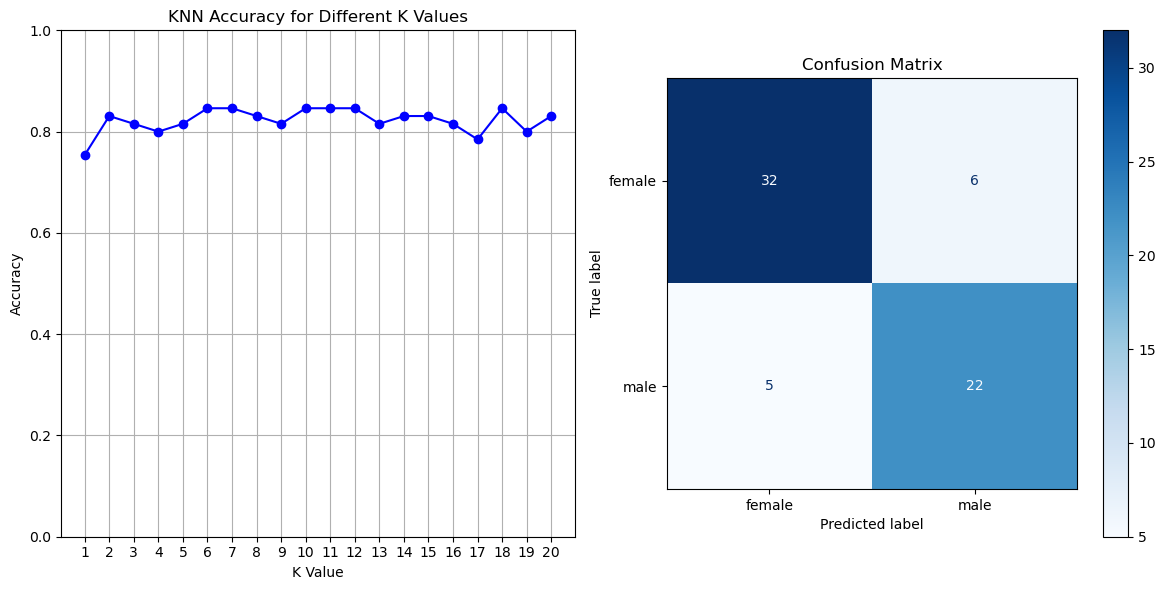

The best K value is: 6


In [445]:
# Check for NaN values in features and target
print("NaN values in features:")
print(features.isnull().sum())
print("NaN values in target:")
print(target.isnull().sum())


df_cleaned = df.dropna()

# Now, update features and target after cleaning
features = df_cleaned[['flipper_length_mm', 'bill_depth_mm']]
target = df_cleaned['sex']

# Continue with your original code
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize lists to store accuracy results
k_values = range(1, 21)  # Test K values from 1 to 20
accuracies = []

# Loop through different K values and evaluate the model
for k in k_values:
    # Create KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plot the accuracy results
plt.figure(figsize=(12, 6))

# Plot Accuracy vs K Value
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, marker='o', color='b')
plt.title('KNN Accuracy for Different K Values')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.ylim(0, 1)
plt.grid()

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.subplot(1, 2, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=knn.classes_)
disp.plot(ax=plt.gca(), cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Print the best K value
best_k = k_values[np.argmax(accuracies)]
print(f'The best K value is: {best_k}')


In [446]:
# Check for missing values in the target variable
missing_target_df = df[df['sex'].isnull()]
if missing_target_df.shape[0] != 0:
    # Create a new DataFrame for rows with missing target values
    non_missing_target_df = df.dropna(subset=['sex'])

    # Separate features and target for the non-missing data
    X_non_missing = non_missing_target_df[['flipper_length_mm', 'bill_depth_mm']]
    y_non_missing = non_missing_target_df['sex']

    # Split the non-missing data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_non_missing, y_non_missing, test_size=0.2, random_state=42)

    # Initialize the KNN classifier with the best K value
    knn_best = KNeighborsClassifier(n_neighbors=best_k)

    # Fit the model on the training data
    knn_best.fit(X_train, y_train)

    # Prepare features for the missing target data
    X_missing = missing_target_df[['flipper_length_mm', 'bill_depth_mm']]

    # Predict the missing target values
    predicted_sex = knn_best.predict(X_missing)

    # Fill in the missing target values in the original DataFrame
    df.loc[df['sex'].isnull(), 'sex'] = predicted_sex

    # Verify that there are no remaining NaN values in the 'sex' column
    print("No of missing values: ",df['sex'].isnull().sum())  # Should output 0 if all missing values have been filled
    print("Shape of the dataset:", df.shape)
    
else:
    print("No missing values found in the 'sex' column.")

df.head()

No of missing values:  0
Shape of the dataset: (339, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male


Q2: What is the average body_mass_g for Gentoo penguins? (code)

In [447]:
average_body_mass = df[df['species'] == 'Gentoo']['body_mass_g'].mean()
print(average_body_mass)
print(f"The average body mass for Gentoo penguins is: {average_body_mass:.2f} g")


5077.459016393443
The average body mass for Gentoo penguins is: 5077.46 g


Q3: How do the distributions of bill_length_mm and bill_depth_mm differ between the three penguin species? Analyze the skewness and kurtosis of each feature for different species. (code and explanation)

c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

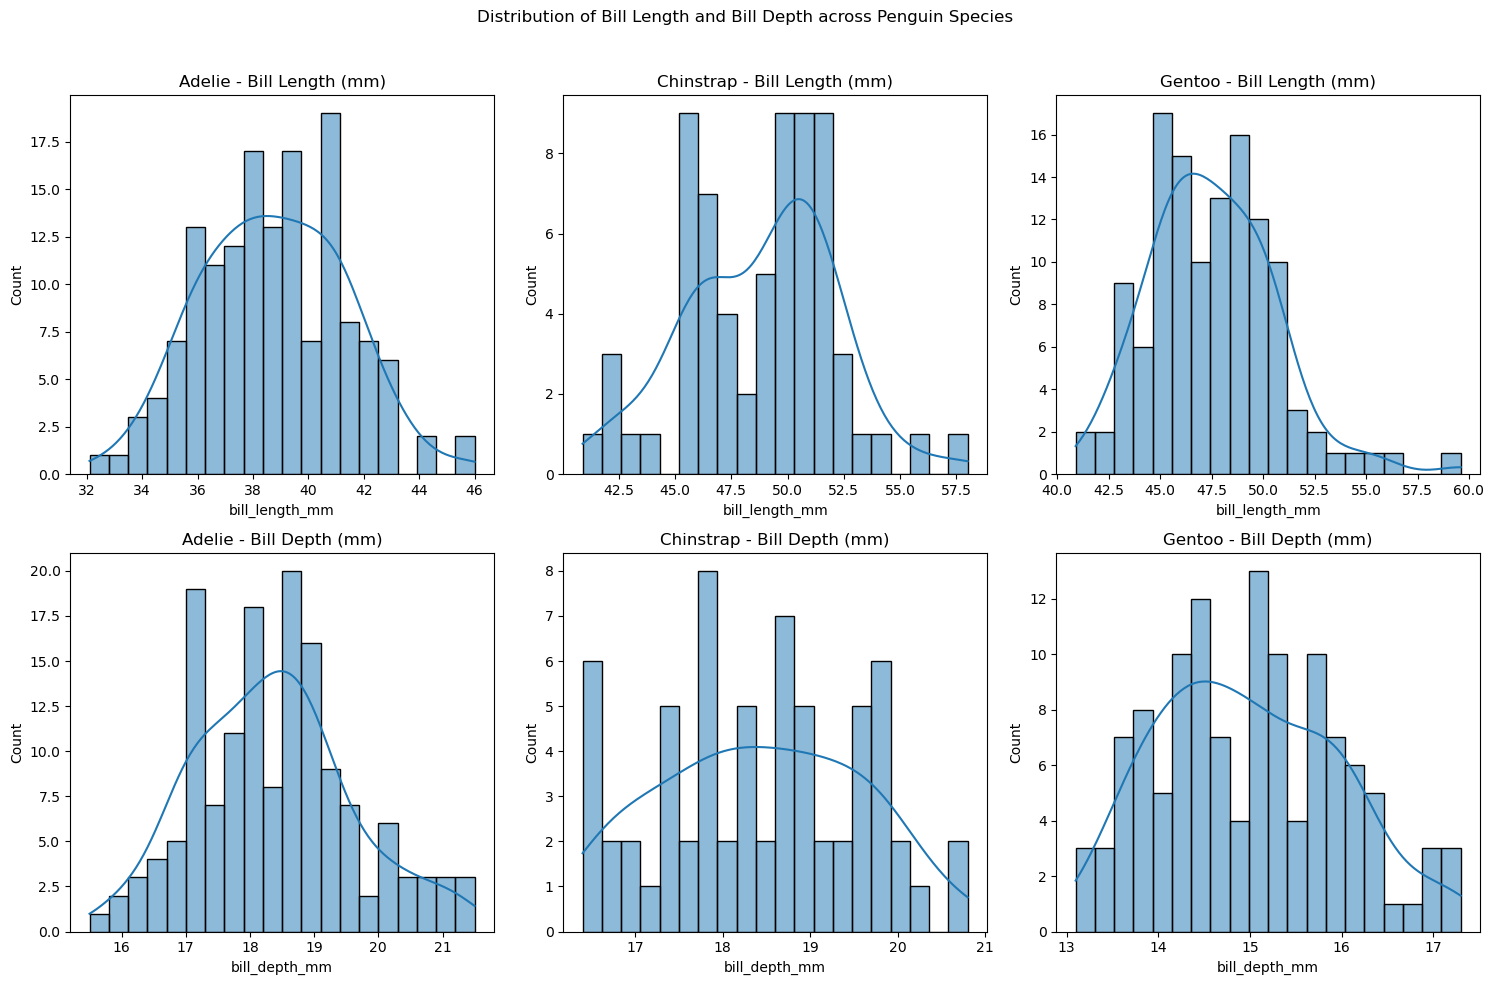


Analysis of bill_length_mm for each species:
Adelie: Skewness = 0.09, Kurtosis = -0.28
Chinstrap: Skewness = -0.09, Kurtosis = 0.01
Gentoo: Skewness = 0.68, Kurtosis = 1.34

Analysis of bill_depth_mm for each species:
Adelie: Skewness = 0.33, Kurtosis = -0.11
Chinstrap: Skewness = 0.02, Kurtosis = -0.93
Gentoo: Skewness = 0.31, Kurtosis = -0.62


In [448]:
# Filter the columns of interest
species_groups = df.groupby('species')

# Create subplots for visualizing distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution of Bill Length and Bill Depth across Penguin Species")

# Plot distributions for bill_length_mm
for idx, (species, group) in enumerate(species_groups):
    sns.histplot(group['bill_length_mm'].dropna(), kde=True, ax=axes[0, idx], bins=20)
    axes[0, idx].set_title(f'{species} - Bill Length (mm)')
    
    sns.histplot(group['bill_depth_mm'].dropna(), kde=True, ax=axes[1, idx], bins=20)
    axes[1, idx].set_title(f'{species} - Bill Depth (mm)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Calculate skewness and kurtosis for each species for bill_length_mm and bill_depth_mm
for feature in ['bill_length_mm', 'bill_depth_mm']:
    print(f"\nAnalysis of {feature} for each species:")
    for species, group in species_groups:
        data = group[feature].dropna()
        feature_skewness = skew(data)
        feature_kurtosis = kurtosis(data)
        print(f"{species}: Skewness = {feature_skewness:.2f}, Kurtosis = {feature_kurtosis:.2f}")


Q4: Identify which features in the dataset have outliers. Provide the method used to detect them and visualize the outliers. (code and explanation)

Outliers for body_mass_g:
       species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
73      Adelie  Torgersen            45.8           18.9              197.0   
206     Gentoo     Biscoe            46.5           14.4              217.0   
324  Chinstrap      Dream            51.5           18.7              187.0   

     body_mass_g     sex  
73       15000.0    male  
206      12000.0  female  
324      10000.0    male  


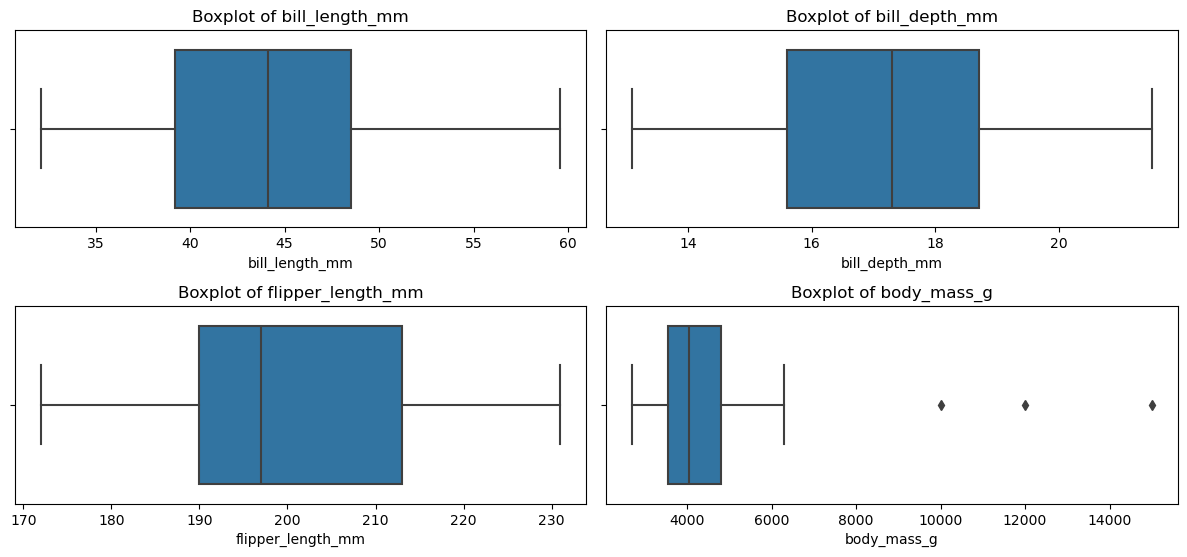

c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

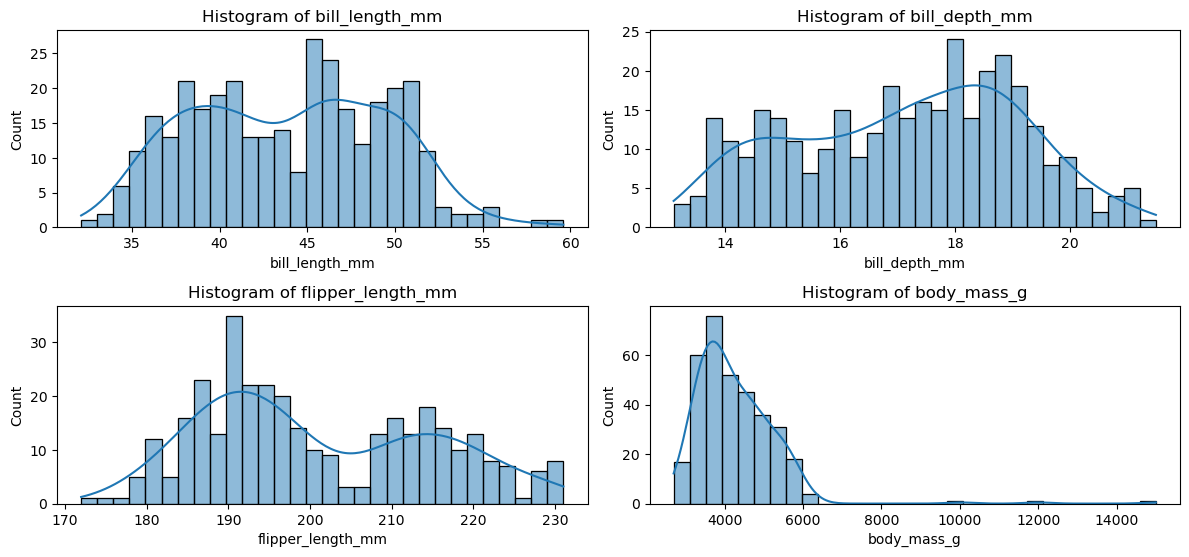

In [449]:
df2 = pd.read_csv(r'D:\Randomwalk\randomwalk-ds-assessment-level2\dataset.csv')

# Function to identify outliers using IQR
def identify_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Identify outliers for each numerical feature
outliers_info = {}
for column in df2.select_dtypes(include=['float64', 'int64']).columns:
    lower, upper = identify_outliers_iqr(df2[column])
    outliers_info[column] = df2[(df2[column] < lower) | (df2[column] > upper)]

# Display outliers for each feature
for feature, outliers in outliers_info.items():
    if outliers.shape[0]:
        print(f"Outliers for {feature}:")
        print(outliers)

# Visualize outliers using boxplots
plt.figure(figsize=(12, 8))
for i, column in enumerate(df2.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 2, i + 1)  # Adjust subplot layout based on number of features
    sns.boxplot(x=df2[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

# Plot histograms for each numerical feature
plt.figure(figsize=(12, 8))
for i, column in enumerate(df2.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df2[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()



Q5: Does this dataset contribute to the curse of dimensionality? If yes perform PCA. (code and explanation required)

In [450]:
# Step 2: One-Hot Encode categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
encoded_columns = encoder.fit_transform(df[categorical_columns])
# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

print("new categorical columns: ",encoded_df.columns)

# Step 3: Combine standardized continuous columns and one-hot encoded categorical columns
df_final = pd.concat([df[continuous_columns], encoded_df], axis=1)

# Display the final transformed DataFrame
print("No of columns in the modified dataset: ",df_final.shape[1])

new categorical columns:  Index(['species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen', 'sex_male'],
      dtype='object')


c:\Users\EG0104TX\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


9

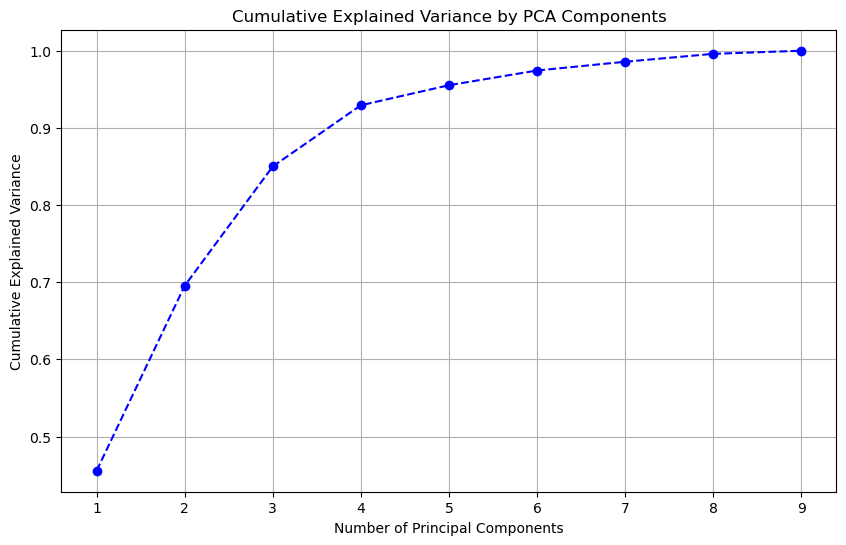

Explained variance ratio by each component:
Component 1: 45.57%
Component 2: 23.97%
Component 3: 15.46%
Component 4: 7.93%
Component 5: 2.60%
Component 6: 1.91%
Component 7: 1.14%
Component 8: 1.02%
Component 9: 0.41%

Number of components to retain at least 95.0% variance: 5


In [451]:
# Combine one-hot encoded categorical features and scaled numeric features
X = df_final

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=X_scaled.shape[1])
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Output the explained variance for each principal component
print("Explained variance ratio by each component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"Component {i+1}: {var*100:.2f}%")

# Set a threshold for cumulative variance (e.g., 95%)
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"\nNumber of components to retain at least {threshold*100}% variance: {num_components}")

Q6: Use bill_length_mm vs bill_depth_mm and plot 7 different graphs to visualize them. (code)

c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\EG0104TX\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

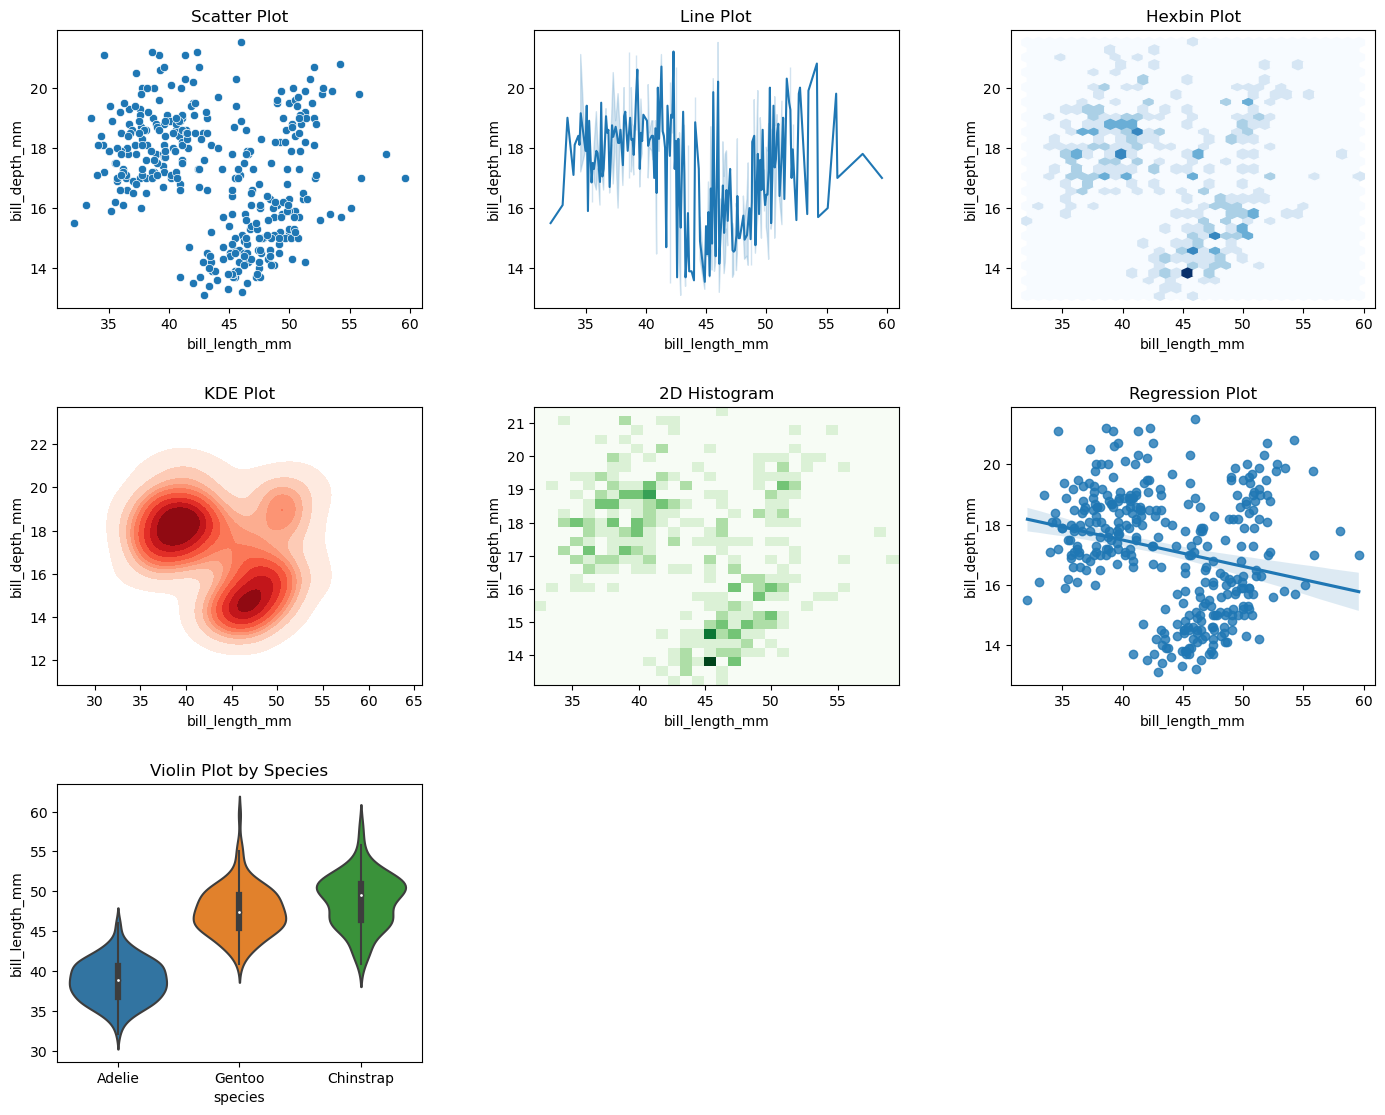

In [452]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Adjust rows/cols to fit your plots, here 3x3
fig.tight_layout(pad=5.0)

# Scatter Plot
sns.scatterplot(data=df, x='bill_length_mm', y='bill_depth_mm', ax=axes[0, 0])
axes[0, 0].set_title("Scatter Plot")

# Line Plot
sns.lineplot(data=df, x='bill_length_mm', y='bill_depth_mm', ax=axes[0, 1])
axes[0, 1].set_title("Line Plot")

# Hexbin Plot (for dense data points)
axes[0, 2].hexbin(df['bill_length_mm'], df['bill_depth_mm'], gridsize=30, cmap='Blues')
axes[0, 2].set_title("Hexbin Plot")
axes[0, 2].set_xlabel("bill_length_mm")
axes[0, 2].set_ylabel("bill_depth_mm")

# KDE (Kernel Density Estimate) Plot
sns.kdeplot(data=df, x='bill_length_mm', y='bill_depth_mm', ax=axes[1, 0], cmap="Reds", fill=True)
axes[1, 0].set_title("KDE Plot")

# 2D Histogram
axes[1, 1].hist2d(df['bill_length_mm'], df['bill_depth_mm'], bins=30, cmap='Greens')
axes[1, 1].set_title("2D Histogram")
axes[1, 1].set_xlabel("bill_length_mm")
axes[1, 1].set_ylabel("bill_depth_mm")

# Joint Plot with Regression
sns.regplot(data=df, x='bill_length_mm', y='bill_depth_mm', ax=axes[1, 2])
axes[1, 2].set_title("Regression Plot")

# Violin Plot (distribution across species, for example)
sns.violinplot(data=df, x='species', y='bill_length_mm', ax=axes[2, 0])
axes[2, 0].set_title("Violin Plot by Species")

# Remove any unused subplots if necessary
for i in range(2, 3):
    for j in range(1, 3):
        fig.delaxes(axes[i, j])

plt.show()


Q7: Find the maximum flipper_length_mm for each combination of species and island. Which species has the longest flippers on each island? (code)

In [453]:
# Group by species and island, then find the maximum flipper length
max_flipper_lengths = df2.groupby(['species', 'island'])['flipper_length_mm'].max().reset_index()

# Find the species with the longest flippers on each island
longest_flippers_per_island = max_flipper_lengths.loc[max_flipper_lengths.groupby('island')['flipper_length_mm'].idxmax()]

# Display the results
print("Maximum flipper length for each species and island combination:")
print(max_flipper_lengths)

print("\nSpecies with the longest flippers on each island:")
print(longest_flippers_per_island)


Maximum flipper length for each species and island combination:
     species     island  flipper_length_mm
0     Adelie     Biscoe              203.0
1     Adelie      Dream              208.0
2     Adelie  Torgersen              210.0
3  Chinstrap      Dream              212.0
4     Gentoo     Biscoe              231.0

Species with the longest flippers on each island:
     species     island  flipper_length_mm
4     Gentoo     Biscoe              231.0
3  Chinstrap      Dream              212.0
2     Adelie  Torgersen              210.0


Q8: Perform z-score normalization on this dataset. (code)

In [454]:
# Step 1: Standardize continuous columns
scaler = StandardScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

# Step 2: One-Hot Encode categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
encoded_columns = encoder.fit_transform(df[categorical_columns])

# Convert the encoded columns to a DataFrame
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_columns))

# Step 3: Combine standardized continuous columns and one-hot encoded categorical columns
df_final = pd.concat([df[continuous_columns], encoded_df], axis=1)

# Display the final transformed DataFrame
df_final.head()

c:\Users\EG0104TX\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_male
0,-0.879396,0.786673,-1.417402,-0.564582,0.0,0.0,0.0,1.0,1.0
1,-0.806092,0.127071,-1.061634,-0.502219,0.0,0.0,0.0,1.0,0.0
2,-0.659484,0.431503,-0.421254,-1.188216,0.0,0.0,0.0,1.0,0.0
3,-1.319220,1.091105,-0.563560,-0.938763,0.0,0.0,0.0,1.0,0.0
4,-0.842744,1.750707,-0.777021,-0.689309,0.0,0.0,0.0,1.0,1.0


In [455]:
# # Select features and target variable
# features = df[['flipper_length_mm', 'bill_depth_mm']]
# target = df['sex']

# # Handle missing values in the target variable (if any)
# target.fillna('unknown', inplace=True)  # Replace unknown with a suitable label if needed

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Initialize lists to store accuracy results
# k_values = range(1, 21)  # Test K values from 1 to 20
# accuracies = []

# # Loop through different K values and evaluate the model
# for k in k_values:
#     # Create KNN classifier
#     knn = KNeighborsClassifier(n_neighbors=k)
    
#     # Fit the model
#     knn.fit(X_train, y_train)
    
#     # Predict on the test set
#     y_pred = knn.predict(X_test)
    
#     # Calculate accuracy
#     accuracy = np.mean(y_pred == y_test)
#     accuracies.append(accuracy)

# # Plot the accuracy results
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, accuracies, marker='o')
# plt.title('KNN Accuracy for Different K Values')
# plt.xlabel('K Value')
# plt.ylabel('Accuracy')
# plt.xticks(k_values)
# plt.grid()
# plt.show()

# # Print the best K value
# best_k = k_values[np.argmax(accuracies)]
# print(f'The best K value is: {best_k}')


In [456]:
# import pandas as pd
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import train_test_split

# # Assume 'df' is your DataFrame with missing values in the 'sex' column
# # Select features and target variable
# features = df[['flipper_length_mm', 'bill_depth_mm']]  # Use numerical features for prediction
# target = df['sex']

# # Create a new DataFrame for rows with missing target values
# missing_target_df = df[df['sex'].isnull()]
# non_missing_target_df = df.dropna(subset=['sex'])

# # Separate features and target for the non-missing data
# X_non_missing = non_missing_target_df[['flipper_length_mm', 'bill_depth_mm']]
# y_non_missing = non_missing_target_df['sex']

# # Split the non-missing data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_non_missing, y_non_missing, test_size=0.2, random_state=42)

# # Initialize the KNN classifier
# knn = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors

# # Fit the model on the training data
# knn.fit(X_train, y_train)

# # Prepare features for the missing target data
# X_missing = missing_target_df[['flipper_length_mm', 'bill_depth_mm']]

# # Predict the missing target values
# predicted_sex = knn.predict(X_missing)

# # Fill in the missing target values in the original DataFrame
# df.loc[df['sex'].isnull(), 'sex'] = predicted_sex

# # Verify that there are no remaining NaN values in the 'sex' column
# print(df['sex'].isnull().sum())  # Should output 0 if all missing values have been filled
